In [2]:
import warnings

warnings.filterwarnings('ignore')

import os

from tools.gradientboostmodeler import GradientBoostModeler
from tools.hyperparamtuning import HyperParamTuning
from nba.common import add_game_log_lag, add_game_log_last_5
import nba.constants as c

from hyperopt import hp

import numpy as np
import pandas as pd

import glob
import shap

ROOT_DIR = os.getcwd()[:-8]


SEED = 1
early_stopping = 50
season = c.SEASON_2022_2023
player_game_log_path = ROOT_DIR + 'data/game_logs/2022-23/player'
player_game_log_csv_files = glob.glob(os.path.join(player_game_log_path, '*.csv'))

log = pd.DataFrame()

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [3]:
# Get Data
for f in player_game_log_csv_files:
    df = pd.read_csv(f)
    log = pd.concat([log, df], ignore_index=True)

log.to_csv(ROOT_DIR + '/data/game_logs/2022-23/player_game_log_2022-2023', index=False)
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,OPP_TEAM_ID
0,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201138,2023-03-29,NYK vs. MIA,W,...,2,0,0,0,1,1,3,-3,2022-23,1.610613e+09
1,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201124,2023-03-27,NYK vs. HOU,W,...,1,1,0,0,0,4,26,11,2022-23,1.610613e+09
2,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201093,2023-03-23,NYK @ ORL,L,...,1,0,2,3,4,5,23,20,2022-23,1.610613e+09
3,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201084,2023-03-22,NYK @ MIA,L,...,4,1,0,1,5,1,15,-6,2022-23,1.610613e+09
4,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201073,2023-03-20,NYK vs. MIN,L,...,4,0,0,0,4,10,57,-6,2022-23,1.610613e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200064,2022-10-26,DEN vs. LAL,W,...,3,4,0,0,3,4,31,28,2022-23,1.610613e+09
1486,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200051,2022-10-24,DEN @ POR,L,...,1,0,0,0,5,4,9,-10,2022-23,1.610613e+09
1487,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200035,2022-10-22,DEN vs. OKC,W,...,3,1,1,0,2,7,19,18,2022-23,1.610613e+09
1488,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200026,2022-10-21,DEN @ GSW,W,...,5,0,0,1,4,10,26,-3,2022-23,1.610613e+09


In [4]:
# Preprocess Data
log = add_game_log_lag(log)
log = add_game_log_last_5(log)
log.sort_values(by=[c.GAME_DATE])
log = log[c.PTS_PREDICTION_MASK]
log.dropna()

X, y = log.drop(c.PTS, axis=1), log[c.PTS]

cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype('category')

In [5]:
# Train Model
rmse = {
    'cv_baseline': 0,
    'base_model': 0,
    'tuned_model': 0,
    'tuned_cv_baseline': 0
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'num_boost_round': 1000
}

gbm = GradientBoostModeler(X, y, SEED)
baseline = gbm.cv(params)
rmse['cv_baseline'] = baseline

gbm.train(params, early_stopping_rounds=early_stopping)
rmse['base_model'] = gbm.rmse()


RSME: 9.082660308017575
[0]	validation-rmse:9.62072	train-rmse:8.65652
[100]	validation-rmse:10.35167	train-rmse:0.16397
[200]	validation-rmse:10.36654	train-rmse:0.00582
[300]	validation-rmse:10.36661	train-rmse:0.00095
[400]	validation-rmse:10.36661	train-rmse:0.00095
[500]	validation-rmse:10.36661	train-rmse:0.00095
[600]	validation-rmse:10.36661	train-rmse:0.00095
[700]	validation-rmse:10.36661	train-rmse:0.00095
[800]	validation-rmse:10.36661	train-rmse:0.00095
[900]	validation-rmse:10.36661	train-rmse:0.00095
[999]	validation-rmse:10.36661	train-rmse:0.00095
RSME: 10.36661399946437


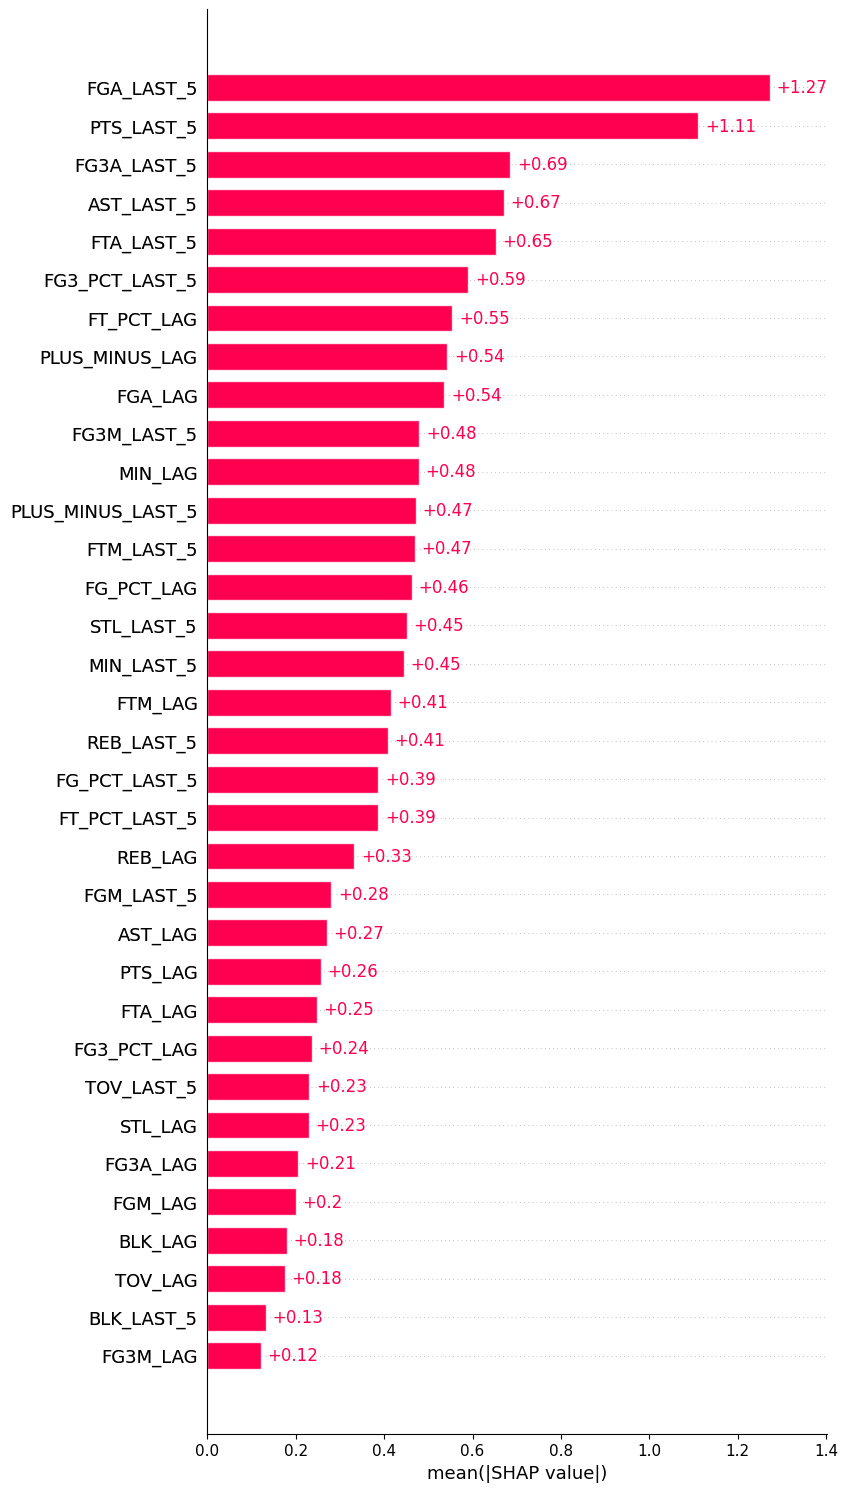

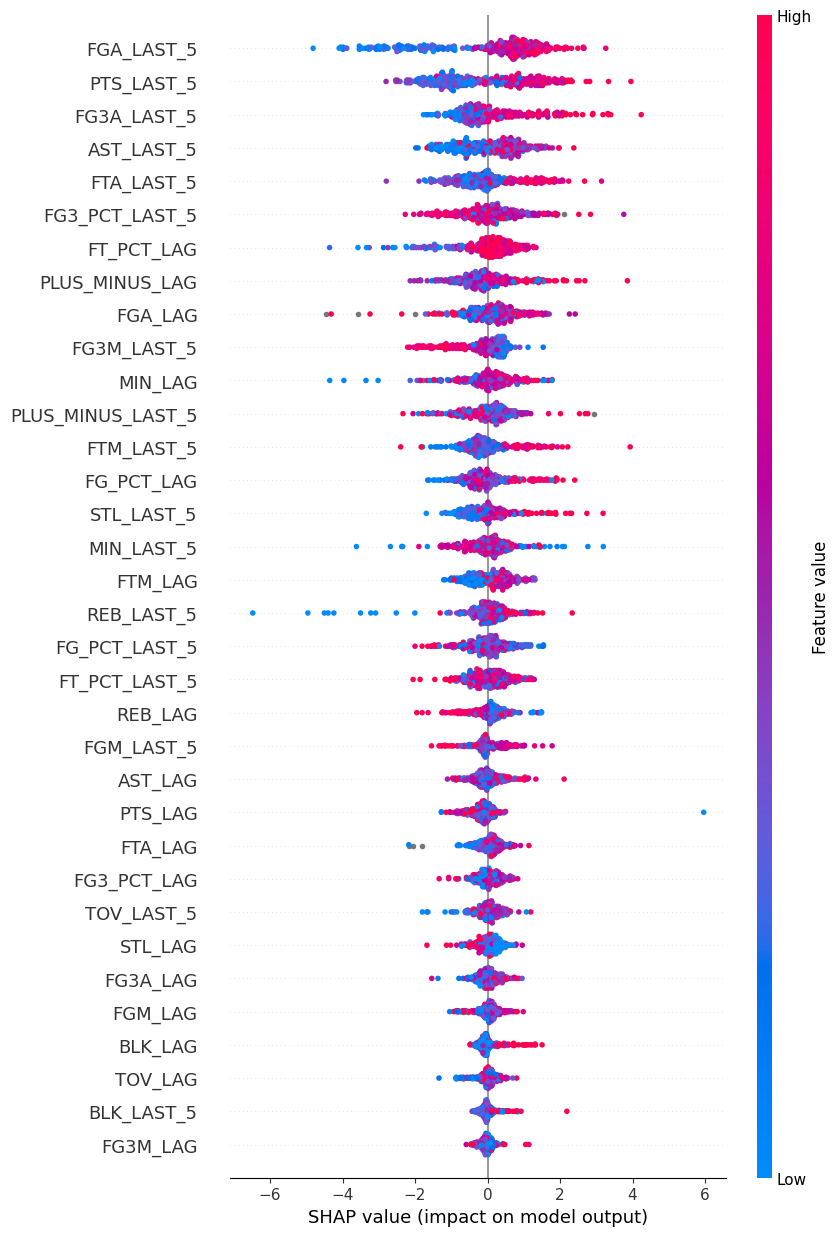

In [6]:
# Plot baseline model
shap.plots.bar(gbm.shap_values(), max_display=100)
shap.plots.beeswarm(gbm.shap_values(), max_display=100)

In [7]:
# Hyperparameter Tuning
space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'num_boost_round': hp.quniform('num_boost_round', 100, 1000, 1),
}

hpt = HyperParamTuning(gbm, space, SEED)
best = hpt.optimize(250)
best

[0]	validation-rmse:9.76424	train-rmse:8.72418         
[100]	validation-rmse:9.73567	train-rmse:4.41375       
[200]	validation-rmse:9.74347	train-rmse:4.03619       
[300]	validation-rmse:9.74550	train-rmse:3.92968       
[303]	validation-rmse:9.74550	train-rmse:3.92968       
RSME: 9.745504506548043                                
[0]	validation-rmse:9.77810	train-rmse:9.14131                                  
[100]	validation-rmse:9.54693	train-rmse:6.78837                                
[114]	validation-rmse:9.55583	train-rmse:6.74805                                
RSME: 9.555827103351973                                                         
[0]	validation-rmse:9.73021	train-rmse:9.01207                                  
[100]	validation-rmse:9.46230	train-rmse:7.07270                                
[200]	validation-rmse:9.47546	train-rmse:6.86234                                
[300]	validation-rmse:9.46531	train-rmse:6.78573                                
[400]	validation

{'colsample_bytree': 0.6612907171662629,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'gamma': 6.5852368199011,
 'max_depth': 3.0,
 'min_child_weight': 0.0,
 'num_boost_round': 570.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 165.0,
 'reg_lambda': 0.1958756309863317,
 'subsample': 1.0}

In [8]:
# Train Tuned Model
gbm.train(best, early_stopping_rounds=early_stopping)
rmse['tuned_model'] = gbm.rmse()
rmse['tuned_cv_baseline'] = gbm.cv(best)
rmse

[0]	validation-rmse:9.82357	train-rmse:9.31373
[95]	validation-rmse:9.30841	train-rmse:8.13216
RSME: 9.308410098496331
RSME: 8.826782966167537


{'cv_baseline': 9.082660308017575,
 'base_model': 10.36661399946437,
 'tuned_model': 9.308410098496331,
 'tuned_cv_baseline': 8.826782966167537}

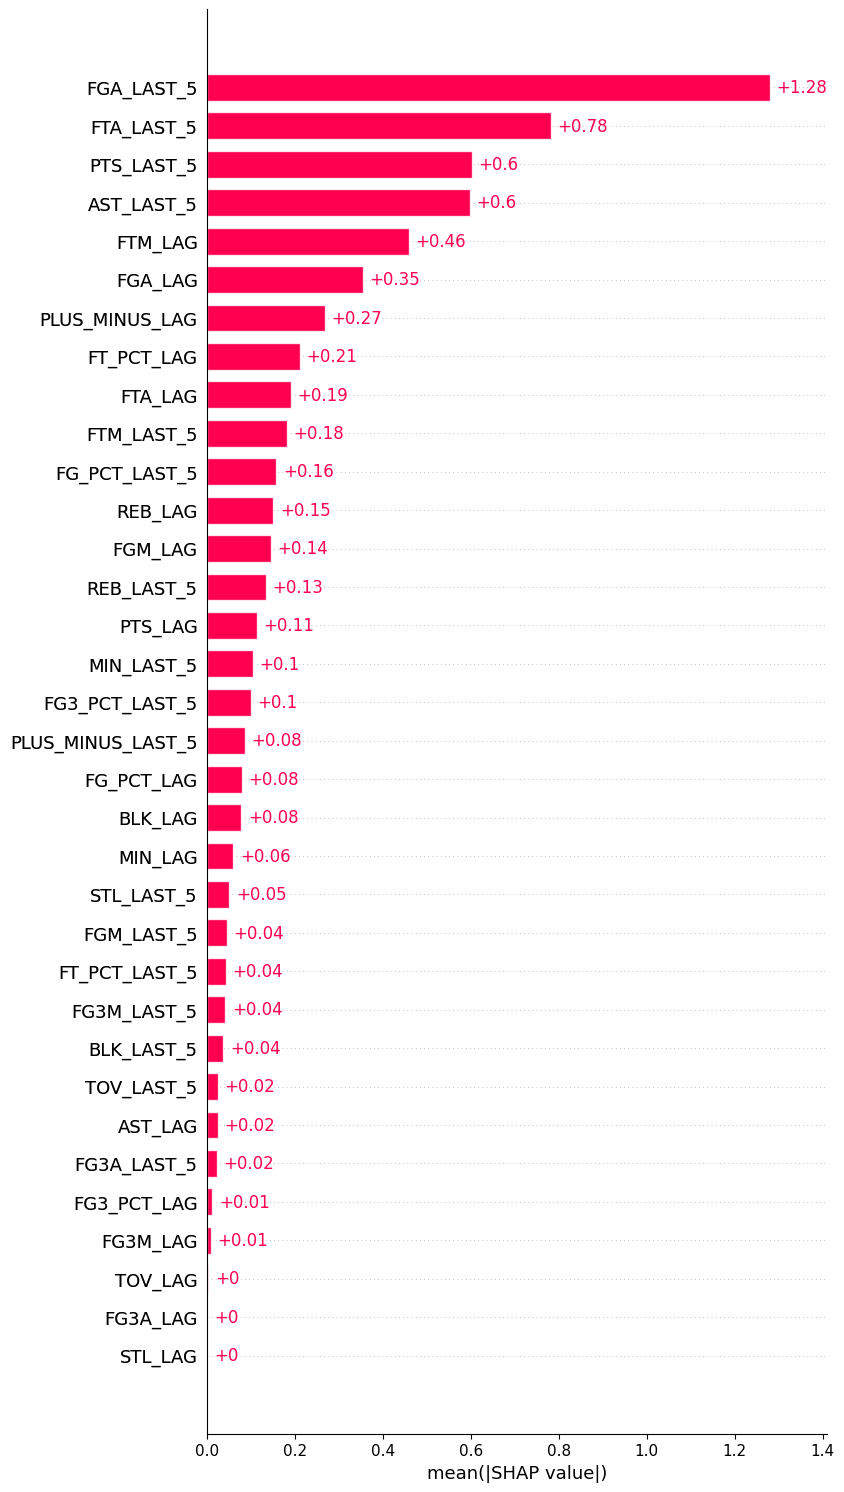

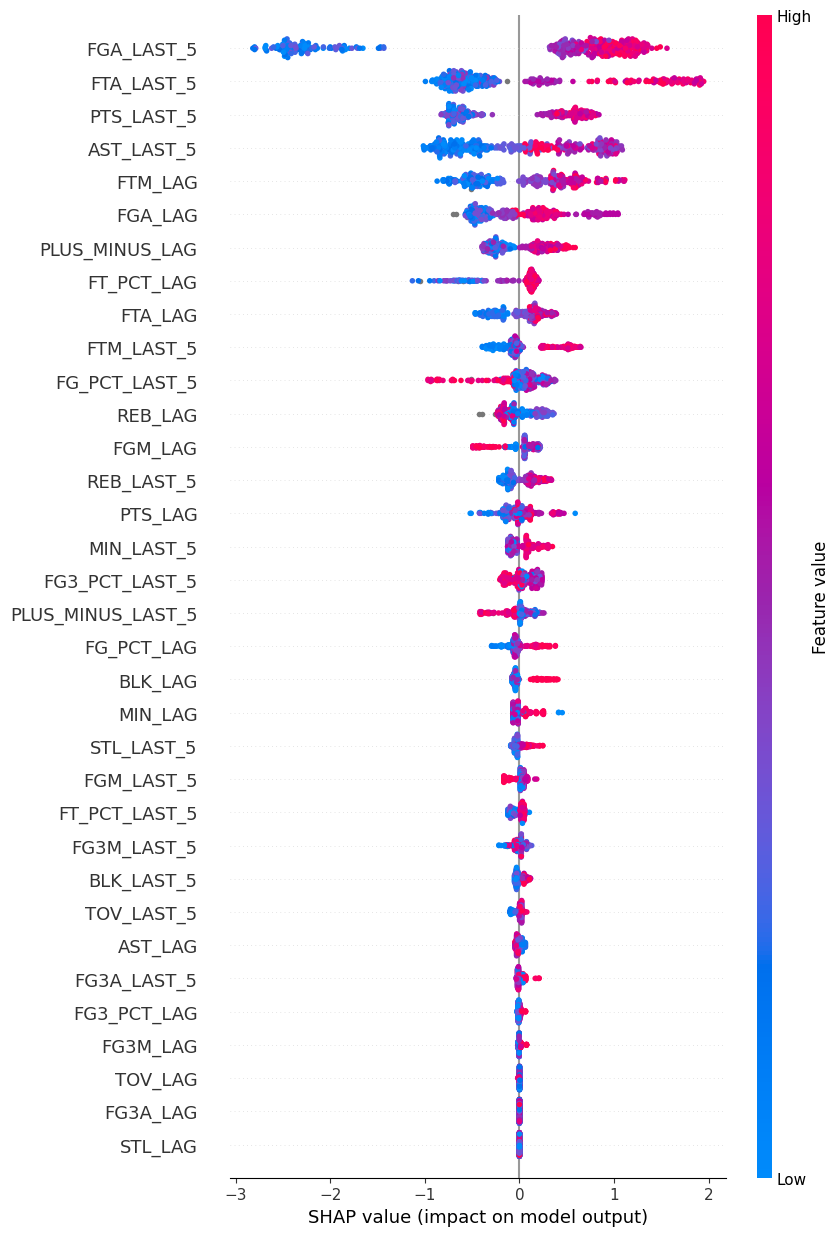

In [9]:
# Plot tuned model
shap.plots.bar(gbm.shap_values(), max_display=100)
shap.plots.beeswarm(gbm.shap_values(), max_display=100)